In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import Voronoi
from scipy.ndimage.morphology import binary_dilation, binary_erosion

import py4DSTEM
from py4DSTEM.process.utils import get_maxima_2D
from py4DSTEM.file.datastructure import PointListArray

/Users/Ben/Code/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#fp = "/home/ben/Data/20190128_ClassificationData/EASY_binDiffraction4.h5"
fp = "/Users/Ben/Desktop/EASY_binDiffraction4_no_datacube.h5"
browser = py4DSTEM.file.readwrite.FileBrowser(fp)
ave_im = browser.get_dataobject('average_image').data2D
deconvolution = browser.get_dataobject('deconvolution').data2D
braggpeaks = browser.get_dataobject('Bragg_peaks')
browser.close()

Q_Nx, Q_Ny = deconvolution.shape
R_Nx,R_Ny = ave_im.shape

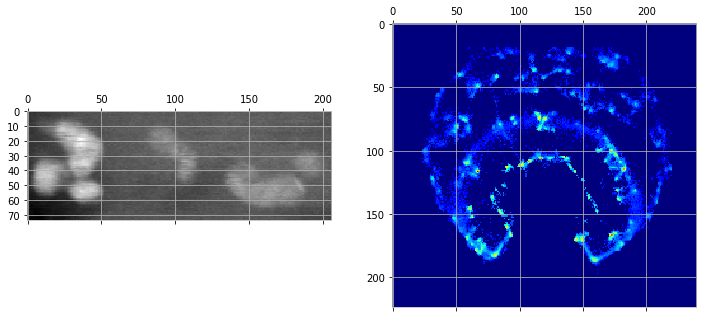

In [3]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(ave_im)
ax2.matshow(deconvolution**0.2,cmap='jet')
plt.show()

In [4]:
# Helper functions

def get_voronoi_vertices(voronoi, nx, ny):
    """From a Voronoi instance, return a list of ndarrays, where each array is shape (N,2), containing the x,y
       positions of the vertices of a voronoi region.
    """
    vertex_list = []
    
    # Get info about ridges extending out of the frame. Include:
    #   -the indices of its vertices, in voronoi.vertices, and
    #   -the indices of its regions (class labels) in voronoi.point_region
    edgeridge_vertices_and_points = []
    for i in range(len(voronoi.ridge_vertices)):
        ridge = voronoi.ridge_vertices[i]
        if -1 in ridge:
            edgeridge_vertices_and_points.append([min(ridge),max(ridge),
                                                  voronoi.ridge_points[i,0],
                                                  voronoi.ridge_points[i,1]])
    edgeridge_vertices_and_points = np.array(edgeridge_vertices_and_points)
    
    # Loop over all regions
    for index in range(len(voronoi.regions)):
        # Get the vertex indices
        vertex_indices = voronoi.regions[index]
        vertices = np.array([0,0])
        # Loop over all vertices
        for i in range(len(vertex_indices)):
            index_current = vertex_indices[i]
            if index_current is not -1:
                vertices = np.vstack((vertices,voronoi.vertices[index_current]))
            else:
                index_prev = vertex_indices[(i-1)%len(vertex_indices)]
                edgeridge_index = int(np.argwhere(edgeridge_vertices_and_points[:,1]==index_prev))
                _,index_vert,region0,region1 = edgeridge_vertices_and_points[edgeridge_index,:]
                x,y = voronoi.vertices[index_vert]
                if (x>0) and (x<nx) and (y>0) and (y<nx):
                    # Get the ridge bisecting two voronoi regions
                    _,index_vert,region0,region1 = edgeridge_vertices_and_points[edgeridge_index,:]
                    x,y = voronoi.vertices[index_vert]
                    x_r0,y_r0 = voronoi.points[region0]   # region0 and region1 voronoi regions
                    x_r1,y_r1 = voronoi.points[region1]   # x_r0, y_r0 is the voronoi point defining this region
                    m = -(x_r1-x_r0)/(y_r1-y_r0)
                    # Choose the direction to extend the ridge
                    ts = np.array([-x, -y/m, nx-x, (ny-y)/m])
                    y_t = lambda t: y+m*t
                    x_t = lambda t: x+t
                    t = ts[np.argmin(np.hypot(x-x_t(ts),y-y_t(ts)))]
                    x_new,y_new = x_t(10*t),y_t(10*t)
                    vertices = np.vstack((vertices,np.array([x_new,y_new])))
                index_next = vertex_indices[(i+1)%len(vertex_indices)]
                edgeridge_index = int(np.argwhere(edgeridge_vertices_and_points[:,1]==index_next))
                _,index_vert,region0,region1 = edgeridge_vertices_and_points[edgeridge_index,:]
                x,y = voronoi.vertices[index_vert]
                if (x>0) and (x<nx) and (y>0) and (y<nx):
                    # Get the ridge bisecting two voronoi regions
                    _,index_vert,region0,region1 = edgeridge_vertices_and_points[edgeridge_index,:]
                    x,y = voronoi.vertices[index_vert]
                    x_r0,y_r0 = voronoi.points[region0]   # region0 and region1 voronoi regions
                    x_r1,y_r1 = voronoi.points[region1]   # x_r0, y_r0 is the voronoi point defining this region
                    m = -(x_r1-x_r0)/(y_r1-y_r0)
                    # Choose the direction to extend the ridge
                    ts = np.array([-x, -y/m, nx-x, (ny-y)/m])
                    y_t = lambda t: y+m*t
                    x_t = lambda t: x+t
                    t = ts[np.argmin(np.hypot(x-x_t(ts),y-y_t(ts)))]
                    x_new,y_new = x_t(10*t),y_t(10*t)
                    vertices = np.vstack((vertices,np.array([x_new,y_new])))
                else:
                    pass
        if len(vertices)<3:
            vertices = np.array([])
        else:
            vertices = vertices[1:,:]
        vertex_list.append(vertices)
    
    return vertex_list

def polygon_mask_from_vertices(xy, nx, ny):
    """From polygon vertices x,y make a boolean mask of the polygon interior
    """
    if len(xy) < 2:
        return np.zeros((nx,ny),dtype=bool)
    poly_verts = [tuple(xy_pair) for xy_pair in xy]
    
    # Make meshgrid, and transform into stack of points
    xx, yy = np.meshgrid(np.arange(nx), np.arange(ny))
    xx, yy = xx.flatten(), yy.flatten()
    points = np.vstack((xx,yy)).T

    path = Path(poly_verts)                # Make matplotlib Path object
    mask = path.contains_points(points)    # Query if each meshgrid pnt is contained
    mask = mask.reshape((ny,nx))

    return mask.T

def get_braggpeak_label_sets_by_scan_position(braggpeaks,x,y):
    """From braggpeak PointListArray and two ndarrays specifying coordinates (x,y) or voronoi points,
       constructs the set of bragg peak labels found at each scan position
    """
    assert isinstance(braggpeaks,PointListArray), "braggpeaks must be a PointListArray"
    assert np.all([name in braggpeaks.dtype.names for name in ('qx','qy')]), "braggpeaks must contain coords 'qx' and 'qy'"
    
    braggpeak_sets_by_scan_position = [[set() for i in range(braggpeaks.shape[1])] for j in range(braggpeaks.shape[0])]
    for Rx in range(braggpeaks.shape[0]):
        for Ry in range(braggpeaks.shape[1]):
                s = braggpeak_sets_by_scan_position[Rx][Ry]
                pointlist = braggpeaks.get_pointlist(Rx,Ry)
                for i in range(pointlist.length):
                    label = np.argmin(np.hypot(x-pointlist.data['qx'][i],y-pointlist.data['qy'][i]))
                    s.add(label)
    
    return braggpeak_sets_by_scan_position

#### Get bragg peaks sets at each scan position

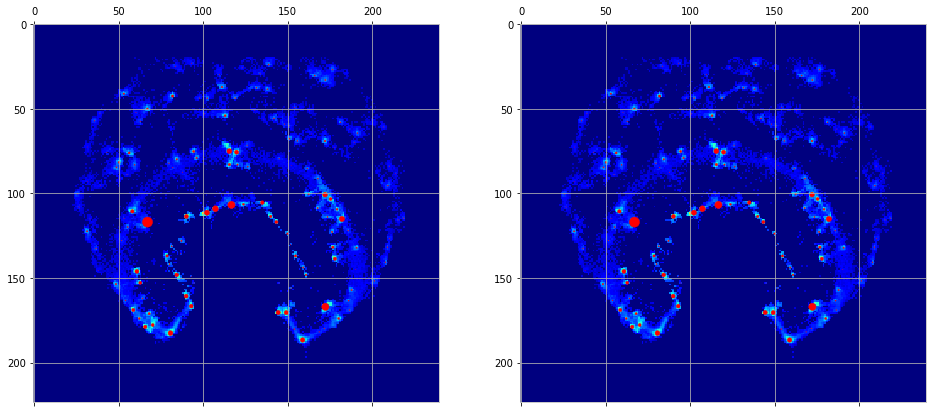

In [5]:
# Get deconvolution maxima

sigma = 1
edgeBoundary = 0
minSpacing = 0
minRelativeIntensity = 0.0005
relativeToPeak = 0
maxNumPeaks = 0
subpixel = True

power = 0.25
scale = 100

maxima_x, maxima_y, maxima_int = get_maxima_2D(deconvolution, sigma=sigma, edgeBoundary=edgeBoundary,
                                               minSpacing=minSpacing, minRelativeIntensity=minRelativeIntensity,
                                               relativeToPeak=relativeToPeak, maxNumPeaks=maxNumPeaks,
                                               subpixel=subpixel)

# Show
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution**power,cmap='jet')
ax1.scatter(maxima_y,maxima_x,color='r',
            s=scale*maxima_int/np.max(maxima_int))
ax2.matshow(deconvolution**power,cmap='jet')
ax2.scatter(maxima_y,maxima_x,color='r',
            s=scale*maxima_int/np.max(maxima_int))
plt.show()

In [6]:
label_sets = get_braggpeak_label_sets_by_scan_position(braggpeaks,maxima_x,maxima_y)

#### Show Voronoi diagram

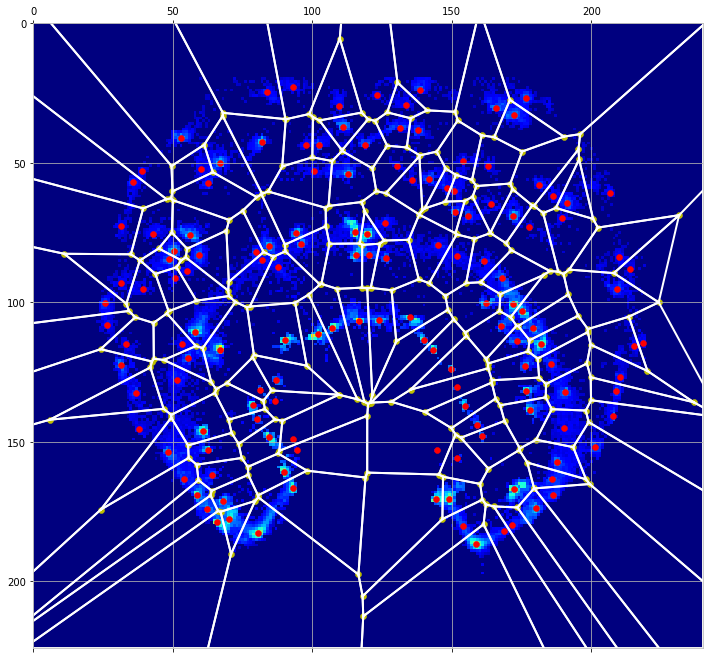

In [7]:
# Make a Voronoi diagram
points = np.vstack((maxima_x,maxima_y)).T
voronoi = Voronoi(points)

# Get vertices
vertices = get_voronoi_vertices(voronoi, Q_Nx, Q_Ny)

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(deconvolution**0.25,cmap='jet')
ax.scatter(voronoi.points[:,1],voronoi.points[:,0],color='r')
ax.scatter(voronoi.vertices[:,1],voronoi.vertices[:,0],color='y')
for region in range(len(vertices)):
    vertices_curr = vertices[region]
    for i in range(len(vertices_curr)):
        x0,y0 = vertices_curr[i,:]
        x1,y1 = vertices_curr[(i+1)%len(vertices_curr),:]
        ax.plot((y0,y1),(x0,x1),'w')        
ax.set_xlim([0,deconvolution.shape[1]])
ax.set_ylim([0,deconvolution.shape[0]])
plt.gca().invert_yaxis()
plt.show()

#### Define connection. Calculate between all adjacent pairs of scan positions.
Keep track of which values came from which scan position pairs.

In [626]:
def intersection(rx1,ry1,rx2,ry2):
    s1 = braggpeak_sets_by_scan_position[rx1][ry1]
    s2 = braggpeak_sets_by_scan_position[rx2][ry2]
    if len(s1)==0 or len(s2)==0:
        return -1
    return len(s1.intersection(s2))

def get_mean_NN_intersection(rx,ry):
    # Interior
    if (rx>0) and (rx<R_Nx-1) and (ry>0) and (ry<R_Ny-1):
        return np.mean((intersection(rx,ry,rx-1,ry-1),intersection(rx,ry,rx-1,ry),intersection(rx,ry,rx-1,ry+1),
                        intersection(rx,ry,rx,ry-1),                                intersection(rx,ry,rx,ry+1),
                        intersection(rx,ry,rx+1,ry-1),intersection(rx,ry,rx+1,ry),intersection(rx,ry,rx+1,ry+1)))
    
    # Corners 
    if rx==0 and ry==0:
        return np.mean((                            intersection(rx,ry,rx,ry+1),
                        intersection(rx,ry,rx+1,ry),intersection(rx,ry,rx+1,ry+1)))
    elif rx==0 and ry==R_Ny-1:
        return np.mean((intersection(rx,ry,rx,ry-1),
                        intersection(rx,ry,rx+1,ry),intersection(rx,ry,rx+1,ry-1)))  
    elif rx==R_Nx-1 and ry==0:
        return np.mean((intersection(rx,ry,rx-1,ry),intersection(rx,ry,rx-1,ry+1),
                                                    intersection(rx,ry,rx-1,ry+1))) 
    elif rx==R_Nx-1 and ry==R_Ny-1:
        return np.mean((intersection(rx,ry,rx-1,ry-1),intersection(rx,ry,rx-1,ry),
                        intersection(rx,ry,rx,ry-1)))
    
    # Edges
    elif rx==0:
        return np.mean((intersection(rx,ry,rx,ry-1),                              intersection(rx,ry,rx,ry+1),
                        intersection(rx,ry,rx+1,ry-1),intersection(rx,ry,rx+1,ry),intersection(rx,ry,rx+1,ry+1)))
    elif rx==R_Nx-1:
        return np.mean((intersection(rx,ry,rx-1,ry-1),intersection(rx,ry,rx-1,ry),intersection(rx,ry,rx-1,ry+1),
                        intersection(rx,ry,rx,ry-1),                              intersection(rx,ry,rx,ry+1)))
    elif ry==0:
        return np.mean((intersection(rx,ry,rx-1,ry),intersection(rx,ry,rx-1,ry+1),
                                                    intersection(rx,ry,rx,ry+1),
                        intersection(rx,ry,rx+1,ry),intersection(rx,ry,rx+1,ry+1)))
    else:
        return np.mean((intersection(rx,ry,rx-1,ry-1),intersection(rx,ry,rx-1,ry),
                        intersection(rx,ry,rx,ry-1),
                        intersection(rx,ry,rx+1,ry-1),intersection(rx,ry,rx+1,ry),))

In [627]:
dx_intersections = np.zeros((R_Nx-1,R_Ny))
dy_intersections = np.zeros((R_Nx,R_Ny-1))

for rx in range(R_Nx-1):
    for ry in range(R_Ny):
        dx_intersections[rx,ry] = intersection(rx,ry,rx+1,ry)
for rx in range(R_Nx):
    for ry in range(R_Ny-1):
        dy_intersections[rx,ry] = intersection(rx,ry,rx,ry+1)

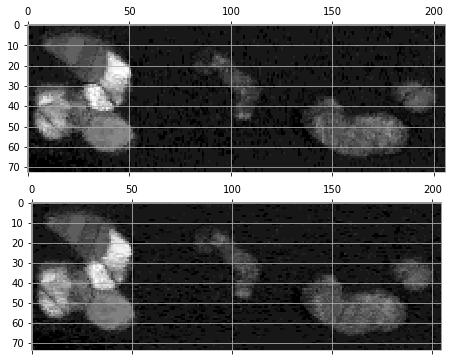

In [628]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,6))
ax1.matshow(dx_intersections)
ax2.matshow(dy_intersections)
plt.show()

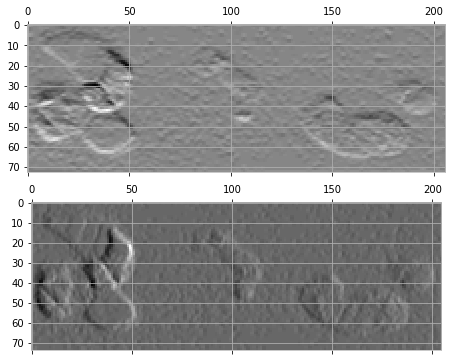

In [629]:
from scipy.signal import convolve2d

sobel_x = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
sobel_y = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,6))
ax1.matshow(convolve2d(x_intersections,sobel_x,mode='same'))
ax2.matshow(convolve2d(y_intersections,sobel_y,mode='same'))
plt.show()

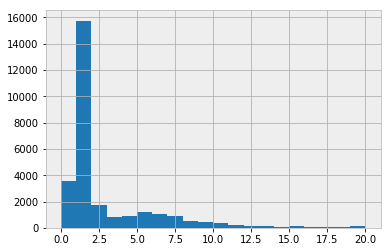

In [630]:
intersections_1d = np.hstack((x_intersections.ravel(),y_intersections.ravel()))

fig,ax=plt.subplots()
ax.hist(intersections_1d,bins=np.arange(max(intersections_1d)))
plt.show()

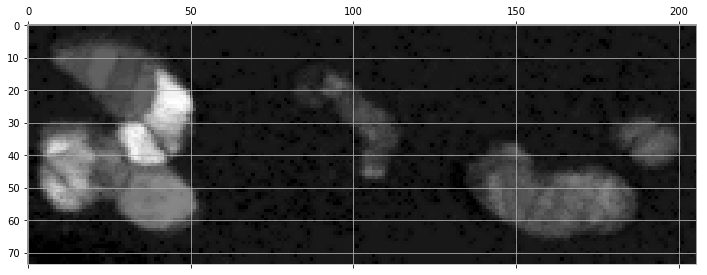

In [634]:
# Get the mean connectedness to 8 NN's
# Find the maxima of this quantity. (Apply small gaussian smoothing, identify local maxima, possibly some thresholding)
# Use these points as seeds for new classes.

mean_NN_intersections = np.zeros((R_Nx,R_Ny))

for rx in range(R_Nx):
    for ry in range(R_Ny):
        mean_NN_intersections[rx,ry] = get_mean_NN_intersection(rx,ry)

fig,ax=plt.subplots(figsize=(12,6))
ax.matshow(mean_NN_intersections)
plt.show()

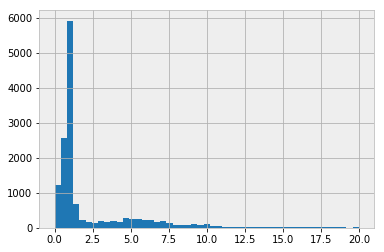

In [635]:
# Histogram
fig,ax=plt.subplots()
ax.hist(mean_NN_intersections.ravel(),bins=np.linspace(0,np.max(mean_NN_intersections),50))
plt.show()

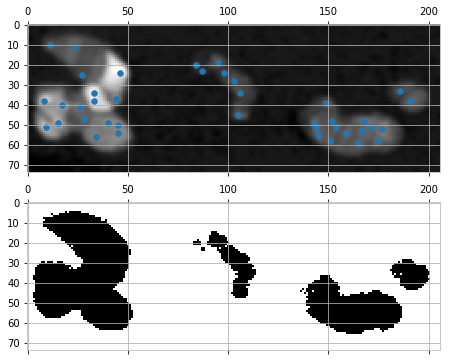

In [636]:
# Get background class mask
# Blur and find local maxima

sigma = 1
thresh_meanNNint = 3

background = mean_NN_intersections < thresh_meanNNint

blurred_mean_intersections = gaussian_filter(mean_NN_intersections,sigma)
maxima_x, maxima_y = np.nonzero(py4DSTEM.process.utils.get_maximal_points(blurred_mean_intersections))

seeds = []
for i in range(len(maxima_x)):
    if mean_NN_intersections[maxima_x[i],maxima_y[i]]>thresh_meanNNint:
        seeds.append([maxima_x[i],maxima_y[i]])
seeds = np.array(seeds)
        
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,6))
ax1.matshow(blurred_mean_intersections)
ax1.scatter(seeds[:,1],seeds[:,0])
ax2.matshow(background)
plt.show()

In [637]:
# From there....do I just grow outward?
#
# Try: grow when the intersection includes, say, 5 peaks
# Compare to just one neighbor? Consider question of growth-edge. How does it extend?

# The Classlabel class

In [952]:
class Classlabel(object):
    """
    The classlabel object contains data pertaining to a single classified region of real space.
    It is a python class object used to classify space into k classes; a class class, if you will. So classy!
    
    This labels scan positions.  That is, this object specifies some sub-region of a 2D array (a boolean array,
    self.mask) which are understood to be members of this class.  Physically, each class is understood to correspond
    to a set of Bragg peaks; the relationship between these peaks in Q-space is left unspecified.
    
    Some diffraction pattern containing the set of Bragg peaks s is deemed more likely to be a member of the class
    if it minimizes the cost function:
    
        $   c = - \sum_i(x_i y_i w_i) + V\sum_i(x_i \logical_xor y_i)   $ 

    Here, the sum is over the set of all N Bragg peaks observed in all the DPs, and:
 
         x              (length N array of bools) self.x[i] is True if $i\in s$, i.e. if the i'th BP is in this DP
         self.y         (length N array of bools) self.y[i] is True if the i'th DP is associated with this class
         self.w         (length N array of floats) self.w[i] quantifies the strength with which we associate the
                                                        i'th DP with the class. (We take a mean.)
         self.V         (int) how strongly we penalize having different Bragg peaks
         
    A Classlabel must be initialized with some starting scan positions, rx, ry, with which to construct and initialize
    self.mask, self.y, and self.w.  We construct self.w from the DPs indicated by rx,ry; self.w[i] is the fraction 
    of class DPs containing the i'th BP.  self.y is given by self.y = self.w > thresh; choose wisely.

    After initialization, we can:
        -get growth mask
        -get cost functions
        -grow
        -shrink?
        -convergence criterion?
    """    
    def __init__(self,index,rx,ry,N,V,thresh):
        """
        Initialize a Classlabel object. 
        
        Accepts:
            index       (int) the class index
            rx,ry       (ints or arrays of ints) initial scan positions
            N           (int) the number of indexed BPs
            V           (float) scales penalty for nonoverlapped Bragg peaks
            thresh      (float) min value of self.w[i] at which self.y[i] is set to True
            
        """
        # Class parameters
        self.index = index
        self.N = N
        self.y = np.zeros(self.N,dtype=bool)
        self.w = np.zeros(self.N,dtype=float)
        self.mask = np.zeros((R_Nx,R_Ny),dtype=bool)
        self.thresh = thresh
        self.V = V
        
        # Machinery
        self.counts_per_BP = np.zeros(self.N,dtype=int)
        self.Ny = 0
            
        # Add initial points
        self.add_data_by_scan_position(rx,ry)
        return

    def add_data_by_scan_position(self,rx,ry):
        if isinstance(rx,np.integer) and isinstance(ry,np.integer):
            if not self.mask[rx,ry]:
                self.mask[rx,ry] = True
                self.Ny += 1
                s = braggpeak_sets_by_scan_position[rx][ry]
                for i in s:
                    self.counts_per_BP[i] += 1
        else:
            assert len(rx)==len(ry)
            for j in range(len(rx)):
                if not self.mask[rx[j],ry[j]]:
                    self.mask[rx[j],ry[j]] = True
                    self.Ny += 1
                    s = braggpeak_sets_by_scan_position[rx[j]][ry[j]]
                    for i in s:
                        self.counts_per_BP[i] += 1
        self.calculate_w()
        self.get_y()
        
    def remove_data_by_scan_position(self,rx,ry):
        if isinstance(rx,np.integer) and isinstance(ry,np.integer):
            if self.mask[rx,ry]:
                self.mask[rx,ry] = False
                self.Ny -= 1
                s = braggpeak_sets_by_scan_position[rx][ry]
                for i in s:
                    self.counts_per_BP[i] -= 1
        else:
            assert len(rx)==len(ry)
            for j in range(len(rx)):
                if self.mask[rx[j],ry[j]]:
                    self.mask[rx[j],ry[j]] = False
                    self.Ny -= 1
                    s = braggpeak_sets_by_scan_position[rx[j]][ry[j]]
                    for i in s:
                        self.counts_per_BP[i] -= 1
        self.calculate_w()
        self.get_y()
        
    def calculate_w(self):
        self.w = self.counts_per_BP/self.Ny
        
    def get_y(self):
        self.y = self.w > self.thresh
        
    def cost(self,s):
        """ $ c = -\sum_i(x_i y_i w_i) + V\sum_i(x_i \logical_xor y_i) $ 
        """
        x = self.s_to_array(s)
        return -np.sum(x*self.y*self.w - self.V*np.logical_xor(x,self.y))
        
    def s_to_array(self,s):
        ans = np.zeros(self.N,dtype=bool)
        for i in s:
            ans[i] = True
        return ans

### Get a first, backgorund class

In [953]:
# Parameters

thresh_meanNNint = 3
V = 2
thresh = 0.05

# Bookkeeping
N_classes = 0
labelled = np.zeros((R_Nx,R_Ny),dtype=bool)   # True for scan positions which have been placed in a class

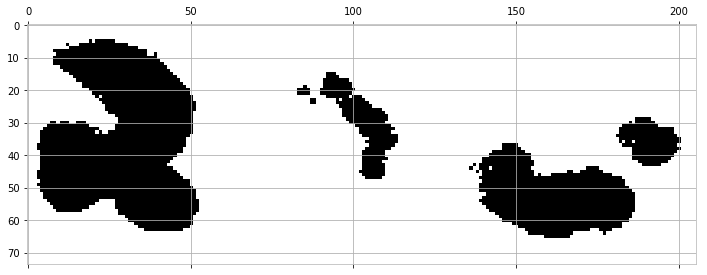

In [954]:
# Get background

background = mean_NN_intersections < thresh_meanNNint

fig,ax=plt.subplots(figsize=(12,6))
ax.matshow(background)
plt.show()

In [955]:
# Make a background class

rx,ry = np.nonzero(background)
background_class = Classlabel(index=N_classes, rx=rx, ry=ry, N=voronoi.npoints, V=V, thresh=thresh)
N_classes+=1
labelled = np.where(background,True,labelled)   # Mark backgroung pixels as in a class

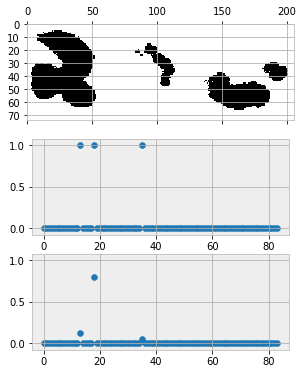

In [956]:
# Show class.mask, class.y

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,6))
ax1.matshow(background_class.mask)
ax2.scatter(np.arange(background_class.N),background_class.y)
ax2.set_aspect(aspect=0.35*background_class.N)
ax2.set_ylim([-0.08,1.08])
ax3.scatter(np.arange(background_class.N),background_class.y*background_class.w)
ax3.set_aspect(aspect=0.35*background_class.N)
ax3.set_ylim([-0.08,1.08])
plt.show()

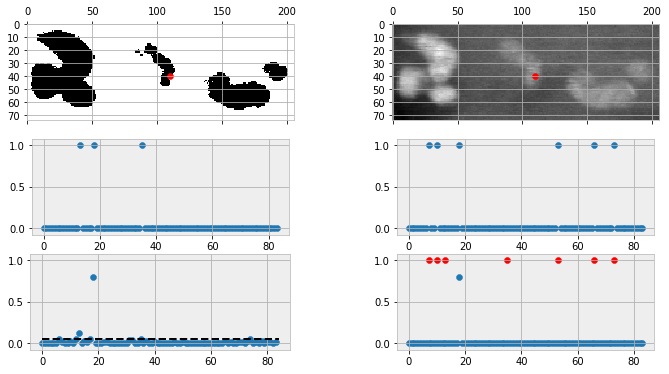

Cost = 13.202097074243193


In [957]:
# Compare class to a DP

rx,ry = 40,110
s = braggpeak_sets_by_scan_position[rx][ry]
x = background_class.s_to_array(s)

fig,((ax_L1,ax_R1),(ax_L2,ax_R2),(ax_L3,ax_R3)) = plt.subplots(3,2,figsize=(12,6))

ax_L1.matshow(background_class.mask)
ax_L1.scatter(ry,rx,color='r')
ax_L2.scatter(np.arange(background_class.N),background_class.y)
ax_L2.set_aspect(aspect=0.35*background_class.N)
ax_L2.set_ylim([-0.08,1.08])
ax_L3.scatter(np.arange(background_class.N),background_class.w)
ax_L3.hlines(background_class.thresh,0,background_class.N,linestyle='--')
ax_L3.set_aspect(aspect=0.35*background_class.N)
ax_L3.set_ylim([-0.08,1.08])

ax_R1.matshow(ave_im)
ax_R1.scatter(ry,rx,color='r')
ax_R2.scatter(np.arange(background_class.N),x)
ax_R2.set_aspect(aspect=0.35*background_class.N)
ax_R2.set_ylim([-0.08,1.08])
ax_R3.scatter(np.arange(background_class.N),x*background_class.y*background_class.w)
xorx = np.nonzero(np.logical_xor(x,background_class.y))[0]
ax_R3.scatter(xorx,np.ones_like(xorx),color='r')
ax_R3.set_aspect(aspect=0.35*background_class.N)
ax_R3.set_ylim([-0.08,1.08])

plt.show()
print("Cost = {}".format(background_class.cost(s)))

### Make and grow and new class

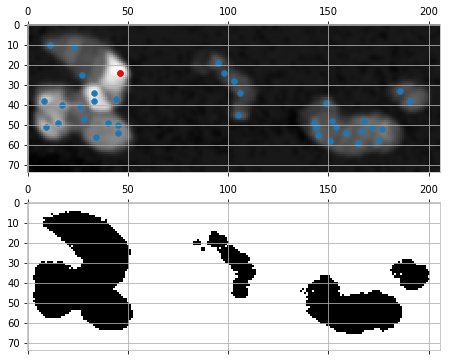

In [958]:
# Get possible locations for seeding new classes
#
# Start with mean intersections.  Apply mild blur, find local maxima.
# When a new seed is needed, get maximum with next-largest mean intersection

sigma = 1
thresh_meanNNint = 3

blurred_mean_intersections = gaussian_filter(mean_NN_intersections,sigma)
maxima_x, maxima_y = np.nonzero(py4DSTEM.process.utils.get_maximal_points(blurred_mean_intersections))

seeds = py4DSTEM.file.datastructure.PointList(coordinates=[('rx',int),('ry',int),('intersection',float)])
for i in range(len(maxima_x)):
    if blurred_mean_intersections[maxima_x[i],maxima_y[i]] > thresh_meanNNint:
        seeds.add_point((maxima_x[i],maxima_y[i],blurred_mean_intersections[maxima_x[i],maxima_y[i]]))
seeds.sort('intersection','descending')

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,6))
ax1.matshow(blurred_mean_intersections)
ax1.scatter(seeds.data['ry'],seeds.data['rx'])
ax1.scatter(seeds.data['ry'][0],seeds.data['rx'][0],color='r')
ax2.matshow(labelled)
plt.show()

In [959]:
# Make a new class. Use maximum and 8 NNs

# Get seed center
rx0,ry0 = seeds.data['rx'][0],seeds.data['ry'][0]

# Get adjacent pixels, handling edges
rx_min = rx0 - 1*(rx0>0)
ry_min = ry0 - 1*(ry0>0)
rx_max = rx0 + 1 + 1*(rx0<(R_Nx-1))
ry_max = ry0 + 1 + 1*(ry0<(R_Ny-1))
rxx,ryy = np.meshgrid(np.arange(rx_min,rx_max),np.arange(ry_min,ry_max))
rx,ry = rxx.ravel(),ryy.ravel()

# Make the new class
current_class = Classlabel(index=N_classes, rx=rx, ry=ry, N=voronoi.npoints, V=V, thresh=thresh)
N_classes+=1
labelled[rx,ry] = True   # Mark backgroung pixels as in a class

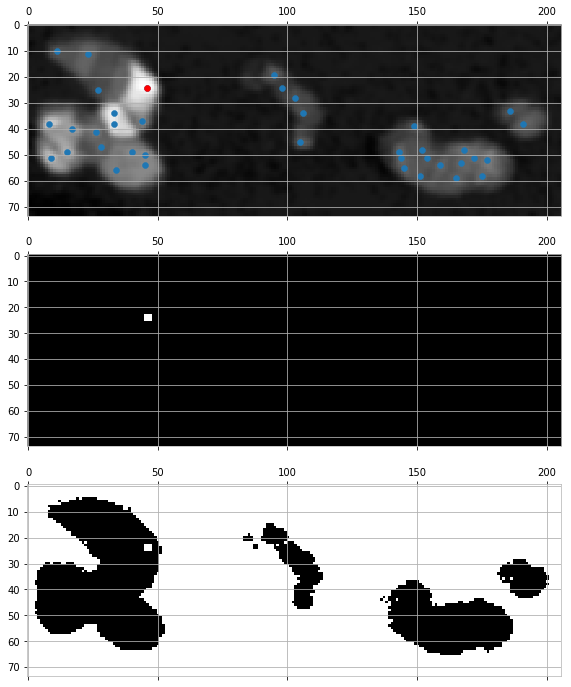

In [960]:
# Show

fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,12))
ax1.matshow(blurred_mean_intersections)
ax1.scatter(seeds.data['ry'],seeds.data['rx'])
ax1.scatter(seeds.data['ry'][0],seeds.data['rx'][0],color='r')
ax2.matshow(current_class.mask)
ax3.matshow(labelled)
plt.show()

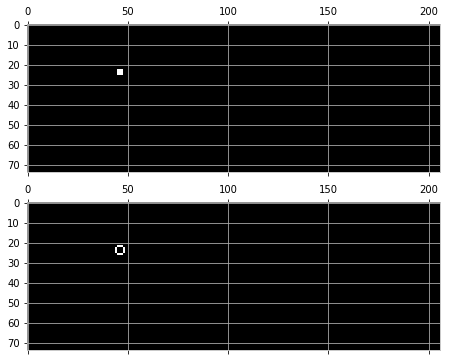

In [961]:
# Get all NN

growth_mask = np.logical_xor(current_class.mask,binary_dilation(current_class.mask))

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
ax1.matshow(current_class.mask)
ax2.matshow(growth_mask)
plt.show()

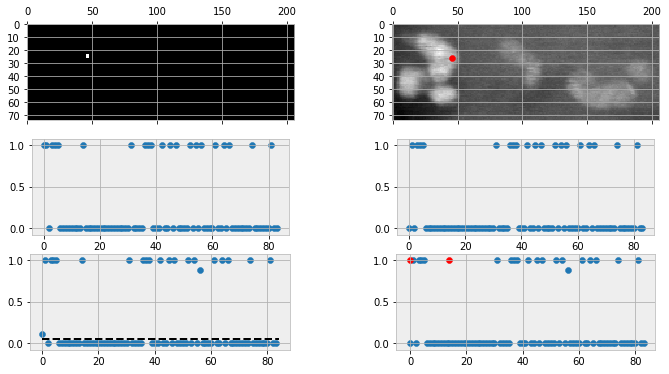

Cost = -14.88888888888889


In [962]:
# Compare class some of these DPs

r_index = 10

rx,ry = np.nonzero(growth_mask)
rx,ry = rx[r_index],ry[r_index]
s = braggpeak_sets_by_scan_position[rx][ry]
x = current_class.s_to_array(s)

fig,((ax_L1,ax_R1),(ax_L2,ax_R2),(ax_L3,ax_R3)) = plt.subplots(3,2,figsize=(12,6))

ax_L1.matshow(current_class.mask)
#ax_L1.scatter(ry,rx,color='r')
ax_L2.scatter(np.arange(current_class.N),current_class.y)
ax_L2.set_aspect(aspect=0.35*current_class.N)
ax_L2.set_ylim([-0.08,1.08])
ax_L3.scatter(np.arange(current_class.N),current_class.w)
ax_L3.hlines(current_class.thresh,0,current_class.N,linestyle='--')
ax_L3.set_aspect(aspect=0.35*current_class.N)
ax_L3.set_ylim([-0.08,1.08])

ax_R1.matshow(ave_im)
ax_R1.scatter(ry,rx,color='r')
ax_R2.scatter(np.arange(current_class.N),x)
ax_R2.set_aspect(aspect=0.35*current_class.N)
ax_R2.set_ylim([-0.08,1.08])
ax_R3.scatter(np.arange(current_class.N),x*current_class.y*current_class.w)
xorx = np.nonzero(np.logical_xor(x,current_class.y))[0]
ax_R3.scatter(xorx,np.ones_like(xorx),color='r')
ax_R3.set_aspect(aspect=0.35*current_class.N)
ax_R3.set_ylim([-0.08,1.08])

plt.show()
print("Cost = {}".format(current_class.cost(s)))

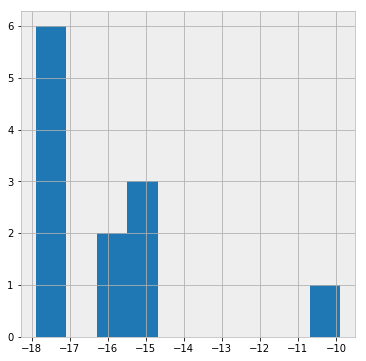

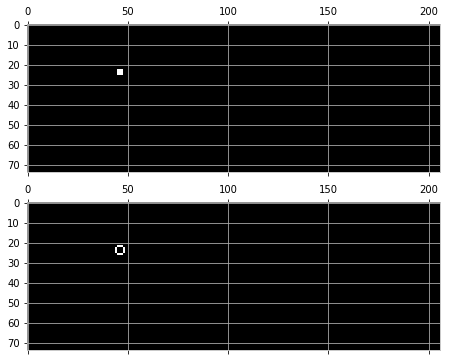

In [963]:
costs = np.zeros_like(np.nonzero(growth_mask)[0])

rx_test,ry_test = np.nonzero(growth_mask)
costs = np.zeros(len(rx_test))

for i in range(len(rx_test)):
    s = braggpeak_sets_by_scan_position[rx_test[i]][ry_test[i]]
    costs[i] = current_class.cost(s)
    
fig,ax=plt.subplots(figsize=(6,6))
ax.hist(costs)
plt.show()

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
ax1.matshow(current_class.mask)
ax2.matshow(growth_mask)
plt.show()

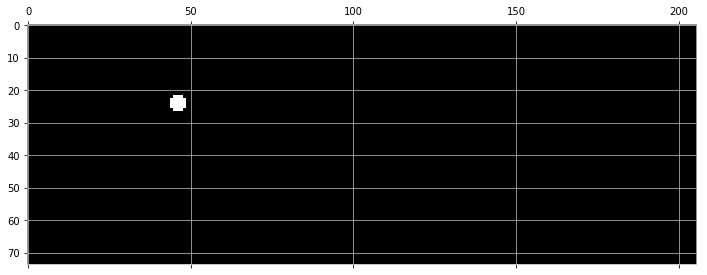

In [964]:
# One growth iteration

growth_mask = np.logical_xor(current_class.mask,binary_dilation(current_class.mask))
rx_test,ry_test = np.nonzero(growth_mask)
costs = np.zeros(len(rx_test))

for i in range(len(rx_test)):
    s = braggpeak_sets_by_scan_position[rx_test[i]][ry_test[i]]
    costs[i] = current_class.cost(s)
    if costs[i] < 0:
        current_class.add_data_by_scan_position(rx_test[i],ry_test[i])
        labelled[rx_test[i],ry_test[i]] = True

fig,ax=plt.subplots(figsize=(12,6))
ax.matshow(current_class.mask)
plt.show()

In [965]:
# One growth iteration

proceed = True
while proceed:
    growth_mask = np.logical_xor(current_class.mask,binary_dilation(current_class.mask))
    rx_test,ry_test = np.nonzero(growth_mask)
    costs = np.zeros(len(rx_test))
    for i in range(len(rx_test)):
        s = braggpeak_sets_by_scan_position[rx_test[i]][ry_test[i]]
        costs[i] = current_class.cost(s)
        if costs[i] < 0:
            current_class.add_data_by_scan_position(rx_test[i],ry_test[i])
            labelled[rx_test[i],ry_test[i]] = True     
    if np.any(costs < 0):
        proceed = True
    else:
        proceed = False

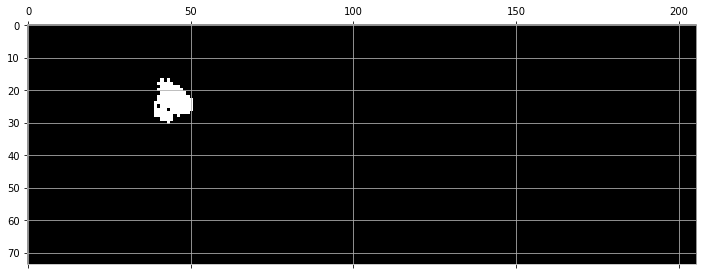

In [966]:
# Show

fig,ax=plt.subplots(figsize=(12,6))
ax.matshow(current_class.mask)
plt.show()

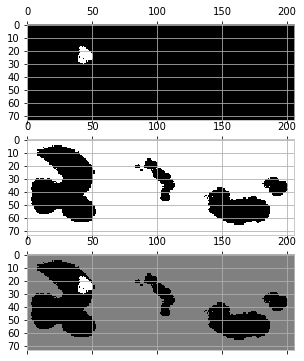

In [967]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,6))
ax1.matshow(current_class.mask)
ax2.matshow(background_class.mask)
ax3.matshow(background_class.mask+2*current_class.mask)
plt.show()

In [1073]:
class Classification(object):
    """
    A classification of a 4D STEM dataset.
    
    A classification object consists of:
        
        classification      (shape (Rx,Ry) array of ints) the class labels k at each scan position
        classes             (len N_classes list of Classlabel objects) the classes
    
    It has the following methods:
        
        new_class(rx,ry)           creates a new class, from the scan position(s) rx,ry
        get_class_mask(i)          returns an (Rx,Ry) ndarray of bools specifying class i scan positions
        grow_class(i,cost_thresh)  expands class i until all its NN DPs have cost >= cost_thresh
        erode_class(i,cost_thresh) erodes class i until all its NN DPs have cost < cost_thresh
    """
    def __init__(self,R_Nx,R_Ny,V,thresh,braggpeak_sets_by_scan_position):
        self.R_Nx, self.R_Ny = R_Nx,R_Ny
        self.classification = -np.ones((self.R_Nx,self.R_Ny),dtype=int)
        self.classes = []
        
        self.V = V
        self.thresh = thresh
        
        self.N_classes = 0
        self.class_indices = []
        self.labelled = np.zeros((self.R_Nx,self.R_Ny),dtype=bool)
        
        self.braggpeak_sets_by_scan_position = braggpeak_sets_by_scan_position
    
    def new_class(self, rx, ry):
        self.N_classes+=1
        self.class_indices=np.arange(self.N_classes)
        curr_class_index = self.class_indices[-1]
        new_class = Classlabel(index=curr_class_index, rx=rx, ry=ry, N=voronoi.npoints, V=self.V, thresh=self.thresh)
        self.classes.append(new_class)
        self.labelled[rx,ry] = True
        self.classification[rx,ry] = curr_class_index
        
    def get_class_mask(self,i):
        return self.classification==i
    
    def grow_class(self,i,cost_thresh):
        current_class = self.classes[i]
        proceed = True
        while proceed:
            growth_mask = np.logical_xor(current_class.mask,binary_dilation(current_class.mask))
            rx,ry = np.nonzero(growth_mask)
            costs = np.zeros(len(rx))
            for j in range(len(rx)):
                s = self.braggpeak_sets_by_scan_position[rx[j]][ry[j]]
                costs[j] = current_class.cost(s)
                if costs[j] < cost_thresh:
                    current_class.add_data_by_scan_position(rx[j],ry[j])
                    self.labelled[rx[j],ry[j]] = True
                    self.classification[rx[j],ry[j]] = i
            if np.any(costs < cost_thresh):
                proceed = True
            else:
                proceed = False

    def erode_class(self,i,cost_thresh):
        current_class = self.classes[i]
        proceed = True
        while proceed:
            erosion_mask = np.logical_xor(current_class.mask,binary_erosion(current_class.mask))
            rx,ry = np.nonzero(erosion_mask)
            costs = np.zeros(len(rx))
            for j in range(len(rx)):
                s = self.braggpeak_sets_by_scan_position[rx[j]][ry[j]]
                costs[j] = current_class.cost(s)
                if costs[j] >= cost_thresh:
                    current_class.remove_data_by_scan_position(rx[j],ry[j])
                    self.labelled[rx[j],ry[j]] = False  
                    self.classification[rx[j],ry[j]] = -1
            if np.any(costs >= cost_thresh):
                proceed = True
            else:
                proceed = False

#### Away we go :D

In [1199]:
V = 1
thresh = 0.05
growth_thresh = 4
erosion_thresh = 4

classification = Classification(R_Nx,R_Ny,V,thresh,braggpeak_sets_by_scan_position)

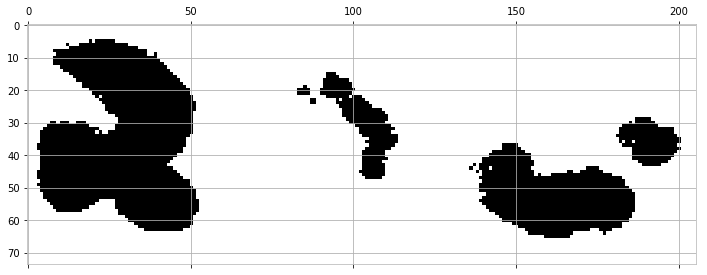

In [1200]:
# Make a background class

background = mean_NN_intersections < thresh_meanNNint

rx,ry = np.nonzero(background)
classification.new_class(rx,ry)

fig,ax=plt.subplots(figsize=(12,6))
ax.matshow(classification.get_class_mask(0))
plt.show()

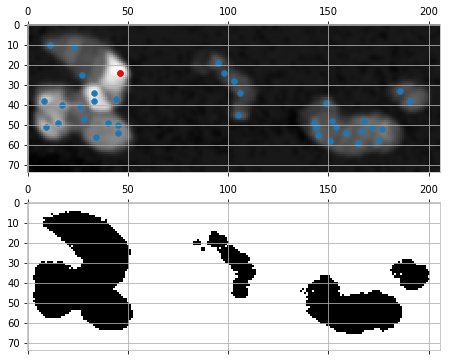

In [1201]:
# Get possible locations for seeding new classes
#
# Start with mean intersections.  Apply mild blur, find local maxima.
# When a new seed is needed, get maximum with next-largest mean intersection

sigma = 1
thresh_meanNNint = 3

blurred_mean_intersections = gaussian_filter(mean_NN_intersections,sigma)
maxima_x, maxima_y = np.nonzero(py4DSTEM.process.utils.get_maximal_points(blurred_mean_intersections))

seeds = py4DSTEM.file.datastructure.PointList(coordinates=[('rx',int),('ry',int),('intersection',float)])
for i in range(len(maxima_x)):
    if blurred_mean_intersections[maxima_x[i],maxima_y[i]] > thresh_meanNNint:
        seeds.add_point((maxima_x[i],maxima_y[i],blurred_mean_intersections[maxima_x[i],maxima_y[i]]))
seeds.sort('intersection','descending')

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,6))
ax1.matshow(blurred_mean_intersections)
ax1.scatter(seeds.data['ry'],seeds.data['rx'])
ax1.scatter(seeds.data['ry'][0],seeds.data['rx'][0],color='r')
ax2.matshow(classification.labelled)
plt.show()

In [1202]:
# Make a new class. Use maximum and 8 NNs

# Get seed center
rx0,ry0 = seeds.data['rx'][0],seeds.data['ry'][0]

# Get adjacent pixels, handling edges
rx_min = rx0 - 1*(rx0>0)
ry_min = ry0 - 1*(ry0>0)
rx_max = rx0 + 1 + 1*(rx0<(R_Nx-1))
ry_max = ry0 + 1 + 1*(ry0<(R_Ny-1))
rxx,ryy = np.meshgrid(np.arange(rx_min,rx_max),np.arange(ry_min,ry_max))
rx,ry = rxx.ravel(),ryy.ravel()

# Make the new class
classification.new_class(rx,ry)

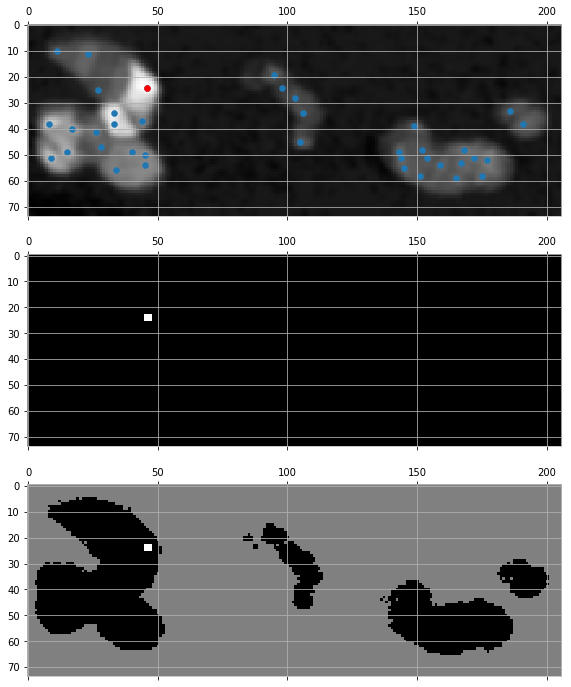

In [1203]:
# Show

fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,12))
ax1.matshow(blurred_mean_intersections)
ax1.scatter(seeds.data['ry'],seeds.data['rx'])
ax1.scatter(seeds.data['ry'][0],seeds.data['rx'][0],color='r')
ax2.matshow(classification.get_class_mask(1))
ax3.matshow(classification.classification)
plt.show()

In [1204]:
# Grow the class

classification.grow_class(1,cost_thresh=growth_thresh)
classification.erode_class(1,cost_thresh=growth_thresh)

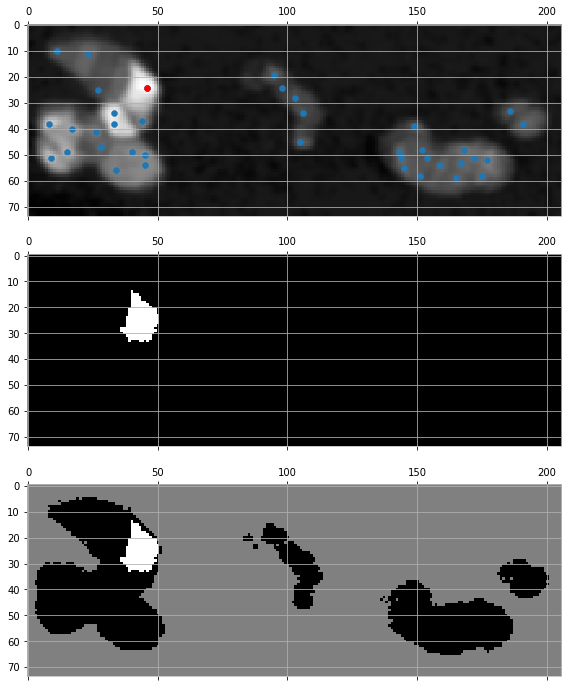

In [1205]:
# Show

fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,12))
ax1.matshow(blurred_mean_intersections)
ax1.scatter(seeds.data['ry'],seeds.data['rx'])
ax1.scatter(seeds.data['ry'][0],seeds.data['rx'][0],color='r')
ax2.matshow(classification.get_class_mask(1))
ax3.matshow(classification.classification)
plt.show()

In [1206]:
# Grow/erode the classes

classification.grow_class(1,cost_thresh=growth_thresh)
classification.erode_class(1,cost_thresh=erosion_thresh)

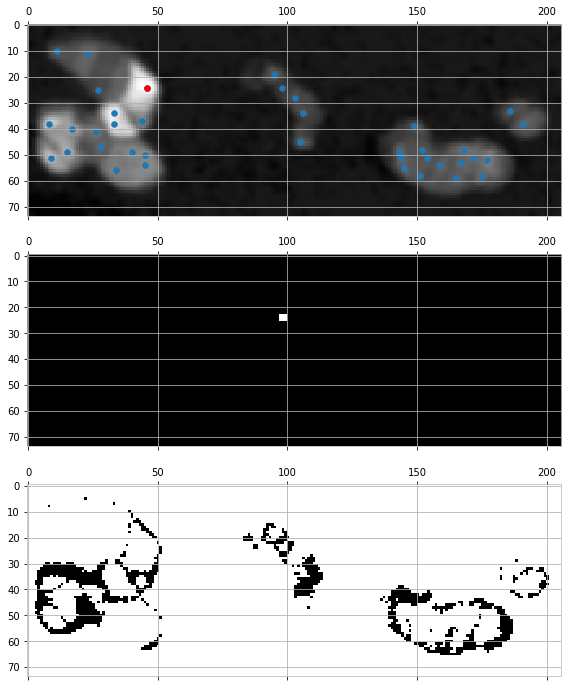

In [1207]:
# Make a bunch of new classes.

r = zip(seeds.data['rx'][1:],seeds.data['ry'][1:])

for rx0,ry0 in r:

    # Get adjacent pixels, handling edges
    rx_min = rx0 - 1*(rx0>0)
    ry_min = ry0 - 1*(ry0>0)
    rx_max = rx0 + 1 + 1*(rx0<(R_Nx-1))
    ry_max = ry0 + 1 + 1*(ry0<(R_Ny-1))
    rxx,ryy = np.meshgrid(np.arange(rx_min,rx_max),np.arange(ry_min,ry_max))
    rx,ry = rxx.ravel(),ryy.ravel()

    # Make the new class
    classification.new_class(rx,ry)
    classification.grow_class(classification.N_classes-1,cost_thresh=growth_thresh)

# Show
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,12))
ax1.matshow(blurred_mean_intersections)
ax1.scatter(seeds.data['ry'],seeds.data['rx'])
ax1.scatter(seeds.data['ry'][0],seeds.data['rx'][0],color='r')
ax2.matshow(classification.get_class_mask(classification.N_classes-1))
ax3.matshow(classification.classification!=-1)
plt.show()

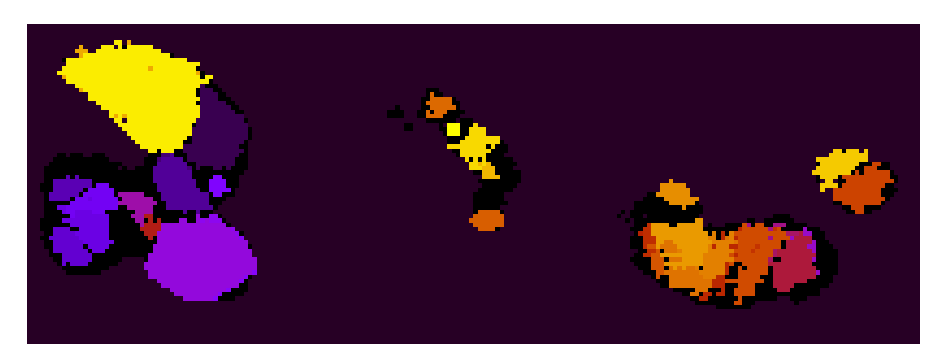

In [1212]:
# Show
fig,ax=plt.subplots(figsize=(16,16))
ax.matshow(classification.classification,cmap='gnuplot')
ax.axis('off')
plt.show()

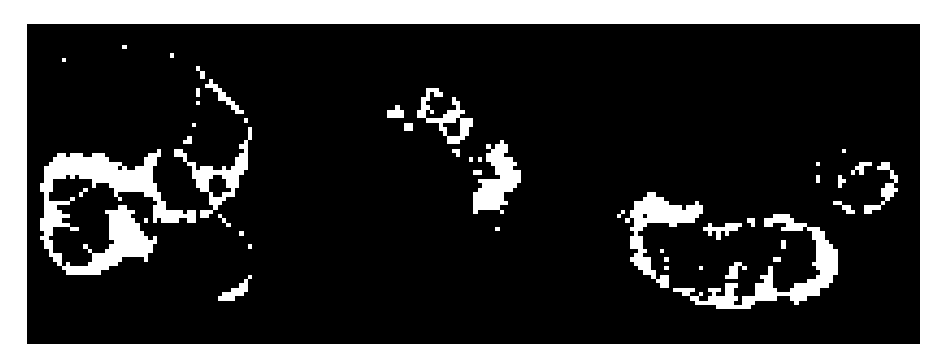

In [1213]:
# Find unassigned regions

# Show
fig,ax=plt.subplots(figsize=(16,16))
ax.matshow(classification.classification==-1)
ax.axis('off')
plt.show()

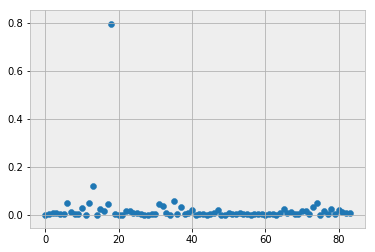

In [565]:
# Show distribution of Bernoulli parameters, phi

fig,ax = plt.subplots()
ax.scatter(np.arange(background_class.N),background_class.phi)
plt.show()

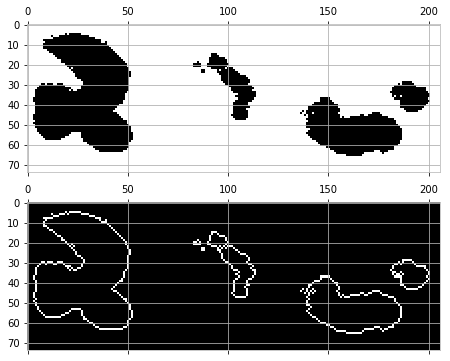

In [566]:
# Get all NNs to class

growth_mask = np.logical_xor(background_class.mask,binary_dilation(background_class.mask))

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
ax1.matshow(background_class.mask)
ax2.matshow(growth_mask)
plt.show()

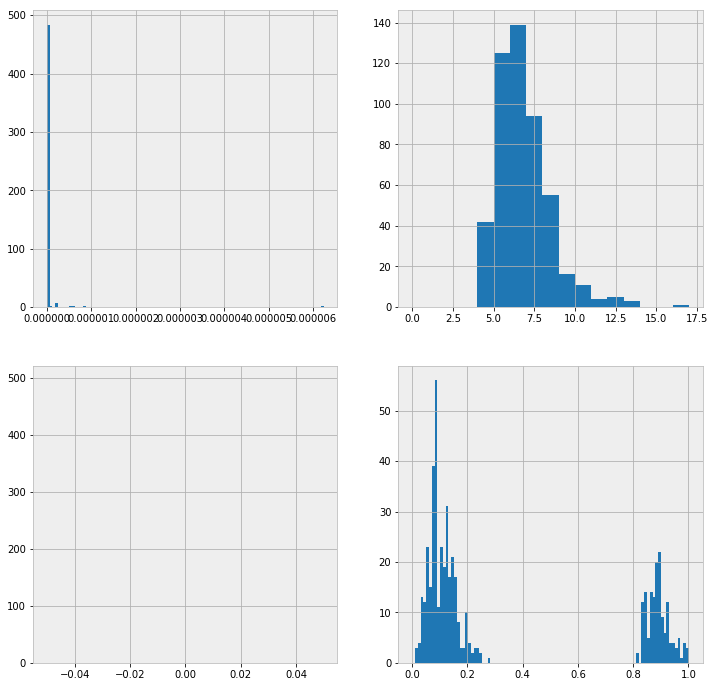

In [569]:
# Metrics for all possible new pixels

rx_test,ry_test = np.nonzero(growth_mask)
P_rxy = np.zeros(len(rx_test))
N_inside_rxy = np.zeros(len(rx_test))
N_inside_rxy_weighted = np.zeros(len(rx_test))
N_outside_rxy = np.zeros(len(rx_test))

for i in range(len(rx_test)):
    s = braggpeak_sets_by_scan_position[rx_test[i]][ry_test[i]]
    P_rxy[i] = background_class.P_s_given_y(s)
    N_inside_rxy[i] = background_class.get_N_inside_class(s)
    N_inside_rxy_weighted[i] = background_class.get_N_inside_class_weighted(s)
    N_outside_rxy[i] = background_class.get_N_outside_class(s)
    
fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.hist(P_rxy,bins=np.linspace(0,np.max(P_rxy),100))
ax12.hist(N_inside_rxy,bins=np.arange(0,np.max(N_inside_rxy)))
ax21.hist(N_outside_rxy,bins=np.linspace(0,np.max(N_outside_rxy),100))
ax22.hist(N_inside_rxy_weighted,bins=np.linspace(0,np.max(N_inside_rxy_weighted),100))
plt.show()

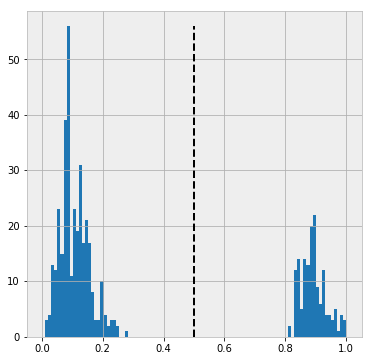

In [579]:
# Set threshold

thresh = 0.5

fig,ax=plt.subplots(figsize=(6,6))
histvals,_,_ = ax.hist(N_inside_rxy_weighted,bins=np.linspace(0,np.max(N_inside_rxy_weighted),100))
ax.vlines(thresh,0,np.max(histvals),linestyle='--')
plt.show()

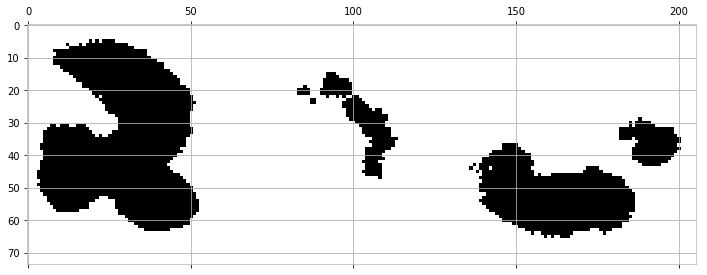

In [580]:
# Expand background

expand_mask = N_inside_rxy_weighted > thresh
rx,ry = rx_test[expand_mask], ry_test[expand_mask]
background_class.add_data_by_scan_position(rx,ry)
labelled[rx,ry] = True
    
fig,ax=plt.subplots(figsize=(12,6))
ax.matshow(background_class.mask)
plt.show()

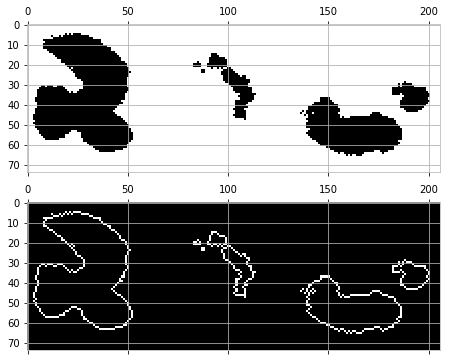

In [581]:
# Get all NNs, again

growth_mask = np.logical_xor(background_class.mask,binary_dilation(background_class.mask))

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
ax1.matshow(background_class.mask)
ax2.matshow(growth_mask)
plt.show()

In [552]:
# Let's call the background done for now. Next...

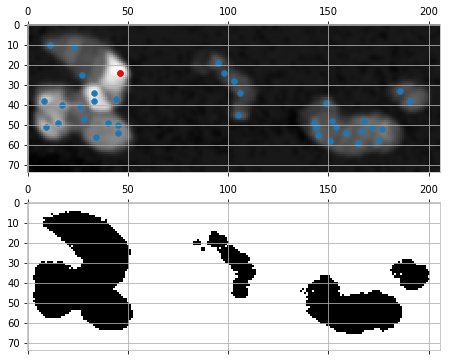

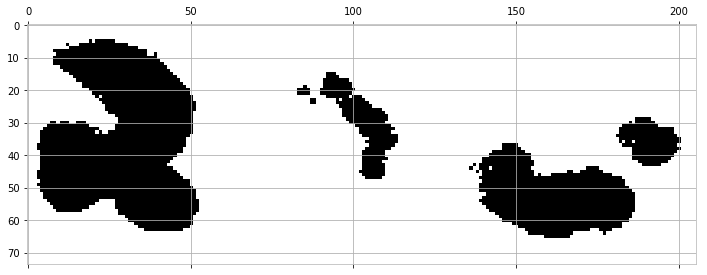

In [554]:
# Make a new class. Use maximum and 8 NNs

rx0,ry0 = seeds.data['rx'][0],seeds.data['ry'][0]

rx = np.arange(rx0-1,rx0+1)

background = mean_NN_intersections < thresh_meanNNint

fig,ax=plt.subplots(figsize=(12,6))
ax.matshow(background)
plt.show()

In [555]:
# Make a new class. Use maximum and 8 NNs

# Get seed center
rx0,ry0 = seeds.data['rx'][0],seeds.data['ry'][0]

# Get adjacent pixels, handling edges
rx_min = rx0 - 1*(rx0>0)
ry_min = ry0 - 1*(ry0>0)
rx_max = rx0 + 1 + 1*(rx0<(R_Nx-1))
ry_max = ry0 + 1 + 1*(ry0<(R_Ny-1))
rxx,ryy = np.meshgrid(np.arange(rx_min,rx_max),np.arange(ry_min,ry_max))
rx,ry = rxx.ravel(),ryy.ravel()

# Make new class
current_class = Classlabel(index=N_classes, rx=rx, ry=ry, N=voronoi.npoints, smoothing_factor=smoothing_factor)
N_classes += 1

# Update labelled array
labelled[rx,ry] = True   # Mark backgroung pixels as in a class

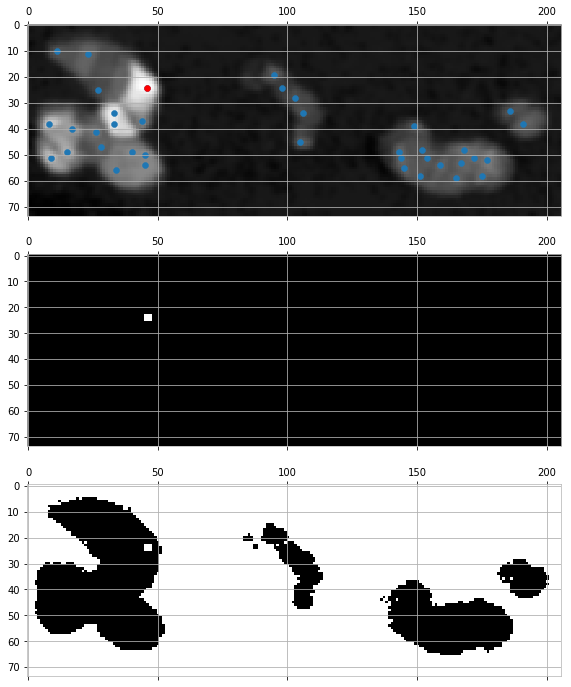

In [556]:
# Show

fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,12))
ax1.matshow(blurred_mean_intersections)
ax1.scatter(seeds.data['ry'],seeds.data['rx'])
ax1.scatter(seeds.data['ry'][0],seeds.data['rx'][0],color='r')
ax2.matshow(current_class.mask)
ax3.matshow(labelled)
plt.show()

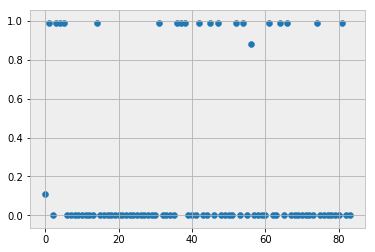

In [557]:
# Show distribution of Bernoulli parameters, phi

fig,ax = plt.subplots()
ax.scatter(np.arange(current_class.N),current_class.phi)
plt.show()

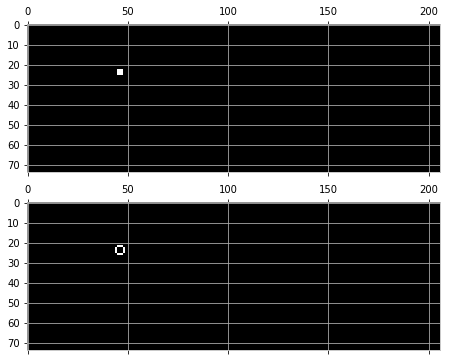

In [558]:
# Get all NN

growth_mask = np.logical_xor(current_class.mask,binary_dilation(current_class.mask))

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
ax1.matshow(current_class.mask)
ax2.matshow(growth_mask)
plt.show()

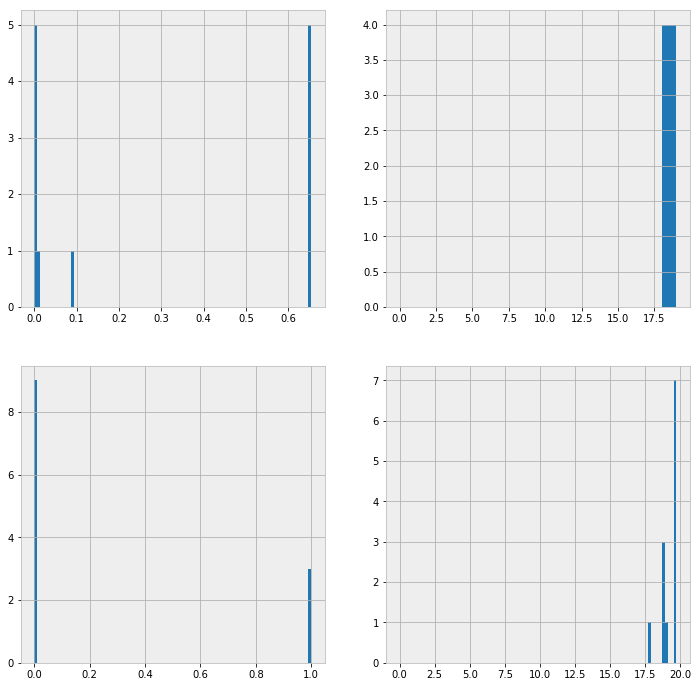

In [559]:
# Metrics for all possible new pixels

rx,ry = np.nonzero(growth_mask)
P_rxy = np.zeros(len(rx))
N_inside_rxy = np.zeros(len(rx))
N_inside_rxy_weighted = np.zeros(len(rx))
N_outside_rxy = np.zeros(len(rx))

for i in range(len(rx)):
    s = braggpeak_sets_by_scan_position[rx[i]][ry[i]]
    P_rxy[i] = current_class.P_s_given_y(s)
    N_inside_rxy[i] = current_class.get_N_inside_class(s)
    N_inside_rxy_weighted[i] = current_class.get_N_inside_class_weighted(s)
    N_outside_rxy[i] = current_class.get_N_outside_class(s)
    
fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.hist(P_rxy,bins=np.linspace(0,np.max(P_rxy),100))
ax12.hist(N_inside_rxy,bins=np.arange(0,np.max(N_inside_rxy)))
ax21.hist(N_outside_rxy,bins=np.linspace(0,np.max(N_outside_rxy),100))
ax22.hist(N_inside_rxy_weighted,bins=np.linspace(0,np.max(N_inside_rxy_weighted),100))
plt.show()

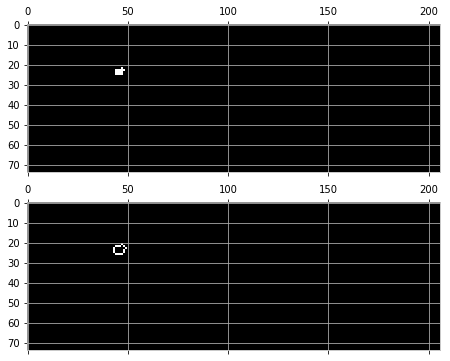

In [511]:
# Expand class, get new growth mask

thresh_growth = 0.5

rx,ry = rx_test[P_rxy>thresh_growth],ry_test[P_rxy>thresh_growth]
current_class.add_data_by_scan_position(rx,ry)
labelled[rx,ry] = True   # Update labelled array

growth_mask = np.logical_xor(current_class.mask,binary_dilation(current_class.mask))

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
ax1.matshow(current_class.mask)
ax2.matshow(growth_mask)
plt.show()

In [89]:
rx,ry = 6,10

np.mean((intersection(rx,ry,rx-1,ry-1),intersection(rx,ry,rx-1,ry),intersection(rx,ry,rx-1,ry+1),
                        intersection(rx,ry,rx,ry-1),intersection(rx,ry,rx,ry+1),
                        intersection(rx,ry,rx+1,ry-1),intersection(rx,ry,rx+1,ry),intersection(rx,ry,rx+1,ry+1)))

2.25

In [93]:
rx,ry = R_Nx,0
if (rx>0) and (rx<R_Nx-1) and (ry>0) and (ry<R_Ny-1):
    val = np.mean((intersection(rx,ry,rx-1,ry-1),intersection(rx,ry,rx-1,ry),intersection(rx,ry,rx-1,ry+1),
                    intersection(rx,ry,rx,ry-1),intersection(rx,ry,rx,ry+1),
                    intersection(rx,ry,rx+1,ry-1),intersection(rx,ry,rx+1,ry),intersection(rx,ry,rx+1,ry+1)))

In [94]:
val

6.125

In [98]:
get_mean_NN_intersection(10,10)

6.125

In [100]:
get_mean_NN_intersections(rx,ry)

/Users/Ben/Code/anaconda2/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Ben/Code/anaconda2/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [101]:
rx,ry

(73, 205)

In [104]:
R_Nx

74

In [638]:
class Classlabel(object):
    """
    The Classlabel object contains data pertaining to a single classified region of real space.
    It is a python class, making this a class class. So classy!
    
    This labels scan positions.  That is, this object specifies some sub-region of a 2D array (a boolean array,
    self.mask) which are understood to be members of this class.  Physically, each class is understood to correspond
    to a set of Bragg peaks; the relationship between these peaks in Q-space is left unspecified.
    
    Operationally, here is how this class works: you initialize it with some region of your scan that you'd like
    to call a class.  You can then grow the class by calling grow().
    
    You can then optimize the class by having it repeatedly grow and shrink against a cost function c, until it
    converges.  (Convergence...is hard, methinks.)
    
    -------------- Defining the class, and its cost function --------------
    
    First things first. The classification scheme begins with feature vectors x.  Each DP has an associated x,
    a length N boolean array, whose element x[i] specifies if the i'th Bragg peak was found in this DP.
    
    Given the x for some initial set of DPs - the canonical examples of this class - the class constructs its own
    length N bool array of DPs associated with it.  For the DPs that are associated with this class, we weight their
    importance by self.w, where self.w[i] is the fraction of the class DPs containing BP i.


    Some diffraction pattern containing the set of Bragg peaks s is deemed more likely to be a member of the class
    if it minimizes the cost function:
        
        $   c = - \sum_i(x_i y_i w_i) + V\sum_i(x_i \logical_xor y_i)   $ 

    A Classlabel must be initialized with some staring scan positions, rx, ry, with which to construct and initialize
    self.mask, self.y, and self.w.  For each DP i, self.w[i] describes the fraction of DPs known to be in this class
    which contain this DP (i.e. the mean of a Bernoulli distribution *puts on fancy hat*).  For each DP i, self.y[i]
    is a boolean which specifies if this DP is considered to be associated with this class.  It's calculated with
    self.y = self.w > thresh.  Choose wisely?!  I should think 0.05-ish would do the trick???? *crosses fingers.
    removes hat.*
    
    After initialization, we can:
        -get growth mask
        -get cost functions
        -grow
        -convergence criterion?
    
    Contains:
        self.index           (int) the class index
        self.N               (int) the number of indexed BPs
                             i.e. the length of the data feature vector, x_i, we'll pass the class from the DPs.
        self.y               (bool) indicates whether each BP is or is not associated with this class
        self.Ny              the number of scan positions in the class
        self.counts_per_BP   the number of scan positions in the class containing each BP
        self.BPs             the indices of the Bragg peaks found in this class
        self.mask            boolean mask of shape (R_Nx,R_Ny), specifying if each pixel is in/out of the class
        self.phi             the pdf parameters; a length N array of floats in [0,1]
                             self.phi[i] is the parameter of a Bernoulli variable for BP x_i, so:
                                      P(x_i=1 | class=thisclass) = phi_i
                             And the full probability distribution is
                                      P(x | class=thisclass) = \prod_{i=1}^{N} P(x_i=1 | class=thisclass)
        self.smoothing_factor The extent to which Laplace smoothing is employed; 0 is no smoothing, 1 is maximal
                             smoothing.
    """    
    def __init__(self,index,rx,ry,N,smoothing_factor=1):
        """
        Initialize a Classlabel object. rx,ry are ints or lists/arrays of ints, specifying initial scan positions in
        the class.
        """
        # Initialize parameters
        self.index = index
        self.N = N
        self.x = 
        self.y = 
        self.Ny = 0
        self.counts_per_BP = np.zeros(N)
        self.mask = np.zeros((R_Nx,R_Ny),dtype=bool)
        self.phi = np.zeros(N)
        self.smoothing_factor = smoothing_factor
        
        # Add points
        self.add_data_by_scan_position(rx,ry)
        return

    def add_data_by_scan_position(self,rx,ry):
        if isinstance(rx,int) and isinstance(ry,int):
            if not self.mask[rx,ry]:
                self.mask[rx,ry] = True
                self.Ny += 1
                s = braggpeak_sets_by_scan_position[rx][ry]
                self.BPs = self.BPs.union(s)
                for BP in s:
                    self.counts_per_BP[BP] += 1
        else:
            assert len(rx)==len(ry)
            for i in range(len(rx)):
                if not self.mask[rx[i],ry[i]]:
                    self.mask[rx[i],ry[i]] = True
                    self.Ny += 1
                    s = braggpeak_sets_by_scan_position[rx[i]][ry[i]]
                    self.BPs = self.BPs.union(s)
                    for BP in s:
                        self.counts_per_BP[BP] += 1
        self.calculate_phi_vals()
    
    def calculate_phi_vals(self):
        self.phi = (self.counts_per_BP + 1*self.smoothing_factor)/(self.Ny + self.N*self.smoothing_factor)
        
    def P_x_given_y(self, x):
        return np.prod(self.phi*x + (1-self.phi)*(1-x))
    
    def P_s_given_y(self, s):
        x = np.zeros(self.N)
        for BP in s:
            x[BP] += 1
        return self.P_x_given_y(x)
    
    def get_N_inside_class(self,s):
        return len(self.BPs.intersection(s))
    
    def get_N_outside_class(self,s):
        return len(s.difference(self.BPs))
    
    def get_N_inside_class_weighted(self,s):
        ans = 0
        for BP in s.intersection(self.BPs):
            ans += self.phi[BP]
        return ans


#### Define connection. Calculate between all adjacent pairs of scan positions.
Keep track of which values came from which scan position pairs.

In [574]:
def get_connection_1(rx1,ry1,rx2,ry2):
    s1 = braggpeak_sets_by_scan_position[rx1][ry1]
    s2 = braggpeak_sets_by_scan_position[rx2][ry2]
    if len(s1)==0 or len(s2)==0:
        return -1
    return len(s1.intersection(s2))/max(len(s1),len(s2))

def get_connection_2(rx1,ry1,rx2,ry2):
    s1 = braggpeak_sets_by_scan_position[rx1][ry1]
    s2 = braggpeak_sets_by_scan_position[rx2][ry2]
    if len(s1)==0 or len(s2)==0:
        return -1
    return len(s1.intersection(s2))/min(len(s1),len(s2))

def get_connection_3(rx1,ry1,rx2,ry2):
    s1 = braggpeak_sets_by_scan_position[rx1][ry1]
    s2 = braggpeak_sets_by_scan_position[rx2][ry2]
    if len(s1)==0 or len(s2)==0:
        return -1
    return len(s1.intersection(s2))

In [575]:
print( get_connection_1(50,40,50,35) )
print( get_connection_2(50,40,50,35) )
print( get_connection_3(50,40,50,35) )

0.9
1.0
9


In [576]:
# Make arrays of NN connection values
#
# x_connections[rx,ry] stores the connection of scan position rx,ry to position rx+1,ry
# y_connections[rx,ry] stores the connection of scan position rx,ry to position rx,ry+1
#
# x_connections has shape (R_Nx-1, R_Ny)
# y_connections has shape (R_Nx, R_Ny-1)

x_connections_1 = np.zeros((R_Nx-1,R_Ny))
x_connections_2 = np.zeros((R_Nx-1,R_Ny))
x_connections_3 = np.zeros((R_Nx-1,R_Ny))
y_connections_1 = np.zeros((R_Nx,R_Ny-1))
y_connections_2 = np.zeros((R_Nx,R_Ny-1))
y_connections_3 = np.zeros((R_Nx,R_Ny-1))

for rx in range(R_Nx-1):
    for ry in range(R_Ny):
        x_connections_1[rx,ry] = get_connection_1(rx,ry,rx+1,ry)
        x_connections_2[rx,ry] = get_connection_2(rx,ry,rx+1,ry)
        x_connections_3[rx,ry] = get_connection_3(rx,ry,rx+1,ry)

for rx in range(R_Nx):
    for ry in range(R_Ny-1):
        y_connections_1[rx,ry] = get_connection_1(rx,ry,rx,ry+1)
        y_connections_2[rx,ry] = get_connection_2(rx,ry,rx,ry+1)
        y_connections_3[rx,ry] = get_connection_3(rx,ry,rx,ry+1)

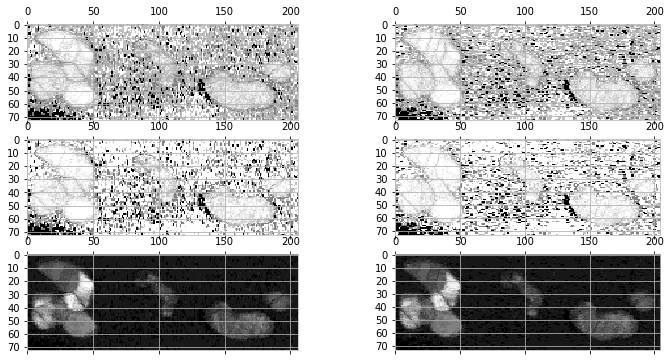

In [577]:
fig,((ax11,ax12),(ax21,ax22),(ax31,ax32))=plt.subplots(3,2,figsize=(12,6))
ax11.matshow(x_connections_1)
ax21.matshow(x_connections_2)
ax31.matshow(x_connections_3)
ax12.matshow(y_connections_1)
ax22.matshow(y_connections_2)
ax32.matshow(y_connections_3)
plt.show()

In [578]:
# Replace -1 values with average of 8 NNs

def replace_unknowns(ar):
    """Unknown ar elements are -1. Replace with NN average
    """
    indices_to_replace = np.argwhere(ar==-1)
    for indices in indices_to_replace:
        rx,ry = indices
        val = np.average((ar[rx-1,ry-1],ar[rx,ry-1],ar[(rx+1)%ar.shape[0],ry-1],
                          ar[rx-1,ry],ar[(rx+1)%ar.shape[0],ry],
                          ar[rx-1,(ry+1)%ar.shape[1]],ar[rx,(ry+1)%ar.shape[1]],
                                      ar[(rx+1)%ar.shape[0],(ry+1)%ar.shape[1]]))
        ar[rx,ry] = val
    return ar

In [579]:
x_connections_1 = replace_unknowns(x_connections_1)
x_connections_2 = replace_unknowns(x_connections_2)
x_connections_3 = replace_unknowns(x_connections_3)
y_connections_1 = replace_unknowns(y_connections_1)
y_connections_2 = replace_unknowns(y_connections_2)
y_connections_3 = replace_unknowns(y_connections_3)

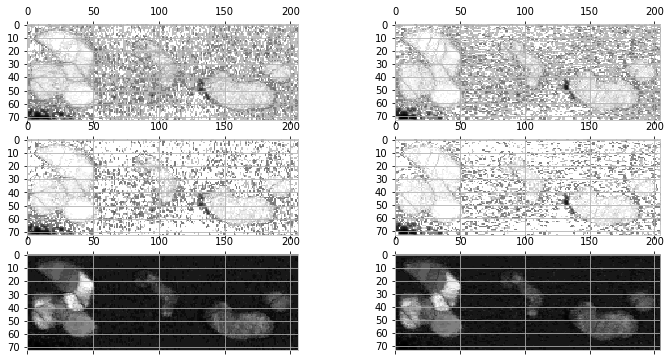

In [580]:
fig,((ax11,ax12),(ax21,ax22),(ax31,ax32))=plt.subplots(3,2,figsize=(12,6))
ax11.matshow(x_connections_1)
ax21.matshow(x_connections_2)
ax31.matshow(x_connections_3)
ax12.matshow(y_connections_1)
ax22.matshow(y_connections_2)
ax32.matshow(y_connections_3)
plt.show()

#### Make histogram of connection values. Decide if this is one class or two+ classes.

In [581]:
connections_1 = np.hstack((x_connections_1.ravel(),y_connections_1.ravel()))
connections_2 = np.hstack((x_connections_2.ravel(),y_connections_2.ravel()))
connections_3 = np.hstack((x_connections_3.ravel(),y_connections_3.ravel()))

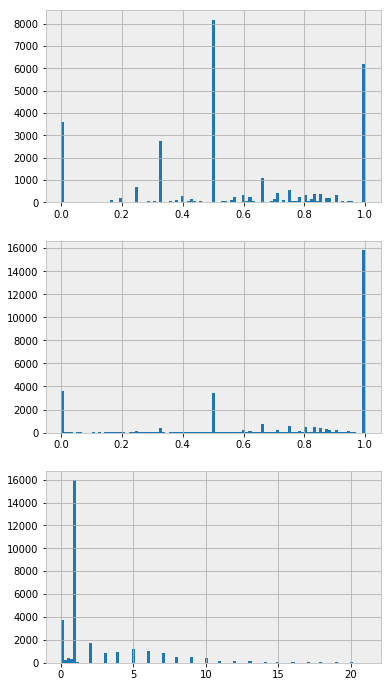

In [588]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(6,12))
ax1.hist(connections_1,bins=np.linspace(0,1,100))
ax2.hist(connections_2,bins=np.linspace(0,1,100))
ax3.hist(connections_3,bins=np.linspace(0,max(connections_3),100))
plt.show()

#### If two: draw a class-boundary line.
Begin by drawing a boundary separating the two scan positions with the lowest connection value. Iterate: at each boundary end, grow in one of the three possible directions, picking the direction of least connection. Grow until hitting a scan edge, or until intersecting with the boundary line itself.

#### Assign class identities (integers) the two new regions created.
For each new class: rinse, repeat. Finish when all classes are determined to be a single class.